In [93]:
import awkward as ak
import h5py
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import os
import yaml
from helpers import load_dataset

mplhep.style.use("CMS")

Als nächstes laden wir die Daten. Dies kann einige Minuten dauern, da **mehrere Millionen** Events eingelesen werden müssen.

In [94]:
datasets = {}
for n, file in enumerate(os.listdir("skimmed_datasets")):
    print(f"Working on {file} ({n + 1}/8)")
    h5file = h5py.File(os.path.join("skimmed_datasets", file), "r")
    datasets.update({file[:-3]: load_dataset(h5file)})
print("Finished!")

Working on ZZTo4e.h5 (1/8)
Working on ZZTo4mu.h5 (2/8)
Working on Run2012B_DoubleMuParked.h5 (3/8)
Working on SMHiggsToZZTo4L.h5 (4/8)
Working on Run2012C_DoubleMuParked.h5 (5/8)
Working on Run2012B_DoubleElectron.h5 (6/8)
Working on Run2012C_DoubleElectron.h5 (7/8)
Working on ZZTo2e2mu.h5 (8/8)
Finished!


Alle events sind nun nach Datensatz geordnet in `datasets` gespeichert. Nun ist es an der Zeit alle für uns irrelevanten Events herauszufiltern. 

In [95]:
def filter_dataset(ds: dict):
    muons = ds["muons"]
    electrons = ds["electrons"]

    ### Myonen
    passes_pt = muons["pt"] > 5
    passes_eta = abs(muons["eta"]) < 2.4
    muons = muons[passes_pt & passes_eta]

    ### Elektronen
    passes_pt = electrons["pt"] > 7
    passes_eta = abs(electrons["eta"]) < 2.5
    electrons = electrons[passes_pt & passes_eta]

    ### Event
    ### Genau 4 Leptonen
    leptons = ak.concatenate((muons, electrons), axis = 1)
    has_4mu = (ak.num(muons) == 4) & (ak.num(electrons) == 0)
    has_4e = (ak.num(muons) == 0) & (ak.num(electrons) == 4)
    has_2mu2e = (ak.num(muons) == 2) & (ak.num(electrons) == 2)
    leptons = leptons[has_4mu | has_4e | has_2mu2e]
    ### Gesamtladung null
    has_0charge = ak.sum(leptons["charge"], axis = 1) == 0
    leptons = leptons[has_0charge]

    ### Massenberechnung
    m4l = ak.sum(leptons.to_xyzt(), axis = 1).mass

    return m4l.to_numpy()

In [91]:
m4l = {}
for name, ds in datasets.items():
    print(f"Working on {name}")
    m4l.update({name: filter_dataset(ds)})
print("Finished!")

Working on ZZTo4e
[[59.5], [64.5], [91.5], [91.1], [93.4], ..., [88.3], [91.2], [90.2], [92]]
Working on ZZTo4mu
[[93.4], [91.7], [65.1], [72.5], [63.4], ..., [91.1], [63.5], [66.8], [92.9]]
Working on Run2012B_DoubleMuParked
[[62.8], [75.6], [60.9], [61.2], [68.5], ..., [55.9], [92], [37.2], [69.5]]
Working on SMHiggsToZZTo4L
[[76.8], [90.5], [59.7], [93.7], [88.6], ..., [80.9], [75.9], [89.3], [90]]
Working on Run2012C_DoubleMuParked
[[57.7], [59.8], [82.1], [93.6], [111], ..., [74], [90.9], [67.8], [60.9]]
Working on Run2012B_DoubleElectron
[[56.4], [102], [65], [66.3], [91.5], ..., [73.1], [93.4], [93.7], [89.4]]
Working on Run2012C_DoubleElectron
[[80.6], [93.3], [59.3], [64.6], [59.7], ..., [86.7], [54.2], [93.1], [90]]
Working on ZZTo2e2mu
[[89.1], [61.9], [92], [59.6], [69.9], ..., [89.5], [93.6], [76.4], [90]]
Finished!


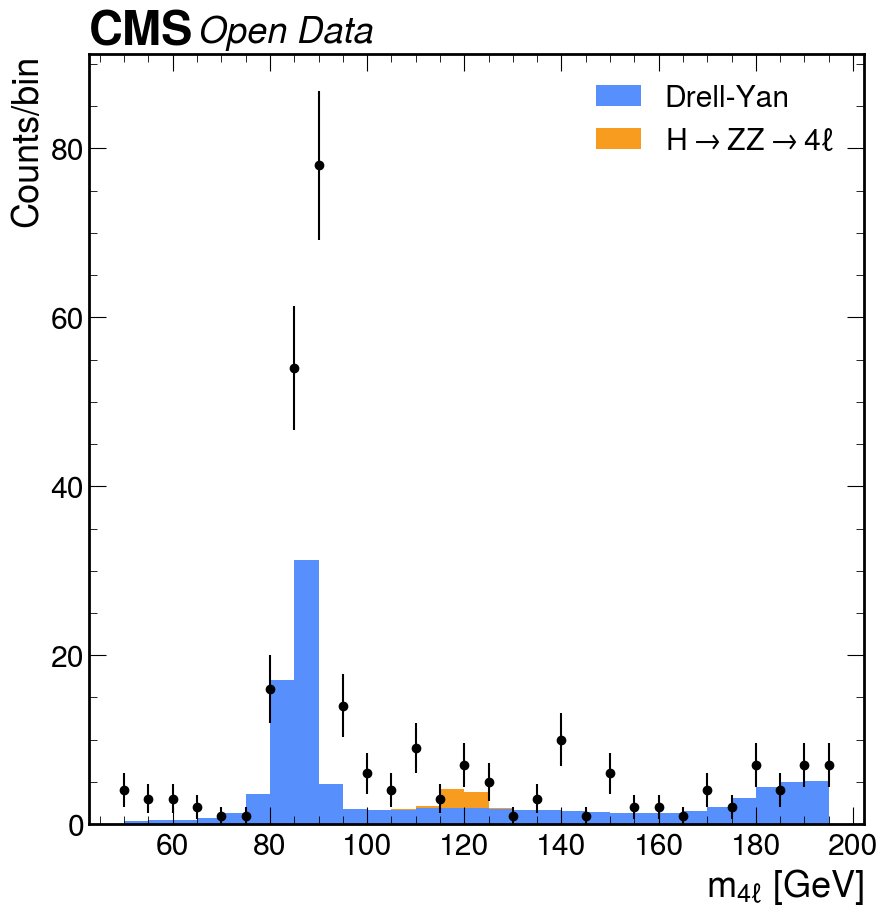

In [66]:
with open("weights.yaml", "r") as wfile: weights = yaml.safe_load(wfile)

### Erstelle Histogramme
bins = np.arange(50, 205, 5)
hists = {
    name: np.histogram(m4l[name], bins)[0] * weights[name] for name in m4l.keys()
}

data = (
    hists["Run2012B_DoubleMuParked"] + hists["Run2012C_DoubleMuParked"]
    + hists["Run2012B_DoubleElectron"] + hists["Run2012C_DoubleElectron"]
)
stat = np.sqrt(data)

mplhep.cms.text("Open Data")
plt.stackplot(
    bins[:-1],
    hists["ZZTo4mu"] + hists["ZZTo4e"] + hists["ZZTo2e2mu"],
    hists["SMHiggsToZZTo4L"],
    labels = ["Drell-Yan", "$H \\rightarrow ZZ \\rightarrow 4\\ell$"],
    step = "pre"
)
plt.errorbar(
    bins[:-1], data, yerr = stat, fmt = "o", color = "black"
)
plt.xlabel("$m_{4\\ell}$ [GeV]")
plt.ylabel("Counts/bin")
plt.legend()
plt.show()